In [1]:
from pyspark.sql import SparkSession
import seaborn as sns

In [2]:
data_dir="data"
spark = SparkSession.builder.master('local[*]').appName('used-car-price').config('spark.executor.memory', '6g').getOrCreate()
spark = SparkSession.builder.master('local[*]').appName('used-car-price')\
.config("spark.executor.instances", "1")\
.config("spark.executor.memory", "6g")\
.config("spark.driver.memory", "6g")\
.config("spark.executor.memoryOverhead", "8g")\
.getOrCreate()

24/09/10 16:40:19 WARN Utils: Your hostname, langchain resolves to a loopback address: 127.0.1.1; using 192.168.0.103 instead (on interface wlp3s0)
24/09/10 16:40:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 16:40:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 16:40:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/10 16:40:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
spark.sparkContext._conf.getAll()

[('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.driver.host', 'langchain.ht.home'),
 ('spark.app.id', 'local-1726000820842'),
 ('spark.driver.

In [4]:
from pyspark.sql.functions import col, count, sum
csv_file_path = '../data/test.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)


In [5]:
df.show()

+------+-------------+--------------------+----------+------+---------+--------------------+--------------------+--------------------+---------+--------------------+-----------+
|    id|        brand|               model|model_year|milage|fuel_type|              engine|        transmission|             ext_col|  int_col|            accident|clean_title|
+------+-------------+--------------------+----------+------+---------+--------------------+--------------------+--------------------+---------+--------------------+-----------+
|188533|         Land|      Rover LR2 Base|      2015| 98000| Gasoline|240.0HP 2.0L 4 Cy...|         6-Speed A/T|               White|    Beige|       None reported|        Yes|
|188534|         Land|   Rover Defender SE|      2020|  9142|   Hybrid|395.0HP 3.0L Stra...|         8-Speed A/T|              Silver|    Black|       None reported|        Yes|
|188535|         Ford|  Expedition Limited|      2022| 28121| Gasoline|3.5L V6 24V PDI D...|  10-Speed Automat

In [6]:
from pyspark.sql.types import NumericType,StringType

# List of numerical columns
numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

#list of string columns
categorical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType)]

print(numerical_columns)
print(categorical_columns)

['id', 'model_year', 'milage']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [7]:
for feature in numerical_columns:
    if feature not in ['id','model_year']: 
        df.select(feature).describe().show()


+-------+-----------------+
|summary|           milage|
+-------+-----------------+
|  count|           125690|
|   mean|66042.58151006444|
| stddev|50223.85843486855|
|    min|              100|
|    max|           405000|
+-------+-----------------+



Summary of milage from trining </br>
+-------+-----------------+</br>
|summary|           milage| </br>
+-------+-----------------+ </br>
| count |           188533| </br>
|   mean| 65705.2951737892| </br>
| stddev|49798.15807575404| </br>
|    min|              100| </br>
|    max|           405000| </br>
+-------+-----------------+

data is quite similary that means there is no data drift for milage

In [8]:
from pyspark.sql.functions import col, sum as sql_sum
null_counts = df.select([sql_sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns])
null_counts.show()


+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+
| id|brand|model|model_year|milage|fuel_type|engine|transmission|ext_col|int_col|accident|clean_title|
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+
|  0|    0|    0|         0|     0|     3383|     0|           0|      0|      0|    1632|      14239|
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+



In [9]:
transmission_un = df.select('transmission').distinct().orderBy('transmission')
transmission_un.show()


+--------------------+
|        transmission|
+--------------------+
|         1-Speed A/T|
|   1-Speed Automatic|
|        10-Speed A/T|
|  10-Speed Automatic|
|10-Speed Automati...|
|                   2|
|         2-Speed A/T|
|   2-Speed Automatic|
|         4-Speed A/T|
|   4-Speed Automatic|
|         5-Speed A/T|
|   5-Speed Automatic|
|         5-Speed M/T|
|       6 Speed At/Mt|
|          6 Speed Mt|
|             6-Speed|
|         6-Speed A/T|
|   6-Speed Automatic|
|6-Speed Automatic...|
|6-Speed Electroni...|
+--------------------+
only showing top 20 rows



In [10]:
df.select("transmission").distinct().count()


52

In [11]:
transmission_counts = df.groupBy('transmission').agg(count('transmission').alias('count')).orderBy('count')
transmission_counts.show(n=52)

+--------------------+-----+
|        transmission|count|
+--------------------+-----+
|         8-SPEED A/T|    8|
|          8-SPEED AT|    9|
|SCHEDULED FOR OR ...|    9|
|7-Speed DCT Autom...|   11|
|               CVT-F|   12|
|Single-Speed Fixe...|   12|
|   2-Speed Automatic|   13|
|       6 Speed At/Mt|   14|
|             6-Speed|   14|
|              Manual|   18|
|             7-Speed|   21|
|      8-Speed Manual|   23|
|9-Speed Automatic...|   28|
|          6 Speed Mt|   29|
|6-Speed Electroni...|   29|
|   4-Speed Automatic|   35|
|10-Speed Automati...|   39|
|                   –|   40|
|                   F|   42|
|         2-Speed A/T|   45|
|            Variable|   58|
|6-Speed Automatic...|   62|
|                   2|   64|
|      7-Speed Manual|   89|
|   7-Speed Automatic|  112|
|Transmission Over...|  124|
|      6-Speed Manual|  130|
|   5-Speed Automatic|  131|
|   1-Speed Automatic|  235|
|         7-Speed M/T|  280|
|8-Speed Automatic...|  345|
|       Automa

In [12]:
brand_un = df.select('brand').distinct().orderBy('brand')
brand_un.show()

+---------+
|    brand|
+---------+
|    Acura|
|     Alfa|
|    Aston|
|     Audi|
|      BMW|
|  Bentley|
|  Bugatti|
|    Buick|
| Cadillac|
|Chevrolet|
| Chrysler|
|    Dodge|
|     FIAT|
|  Ferrari|
|     Ford|
|      GMC|
|  Genesis|
|    Honda|
|   Hummer|
|  Hyundai|
+---------+
only showing top 20 rows



In [13]:
df.select("brand").distinct().count()

55

In [14]:
df.select('accident').distinct().show()

+--------------------+
|            accident|
+--------------------+
|At least 1 accide...|
|       None reported|
|                NULL|
+--------------------+



In [15]:
df.select('fuel_type').distinct().show()

+--------------+
|     fuel_type|
+--------------+
|      Gasoline|
| E85 Flex Fuel|
|        Diesel|
|             –|
|        Hybrid|
|Plug-In Hybrid|
| not supported|
|          NULL|
+--------------+



In [17]:
from fuzzywuzzy import process, fuzz
from pyspark.sql import functions as F
avg_mileage_by_year_df = df.groupBy('model_year').agg(F.mean('milage').alias('avg_milage'))
avg_mileage_by_year_pdf = avg_mileage_by_year_df.toPandas().sort_values('avg_milage',ascending = False)
avg_mileage_by_year_pdf.head(5)

/media/lang_chain/Storage/azure-code/.conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


,model_year,avg_milage
34,1982,179400.000000
9,1997,140374.551402
30,1999,138311.942211
13,2004,131126.768754
25,2000,130118.753541


/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


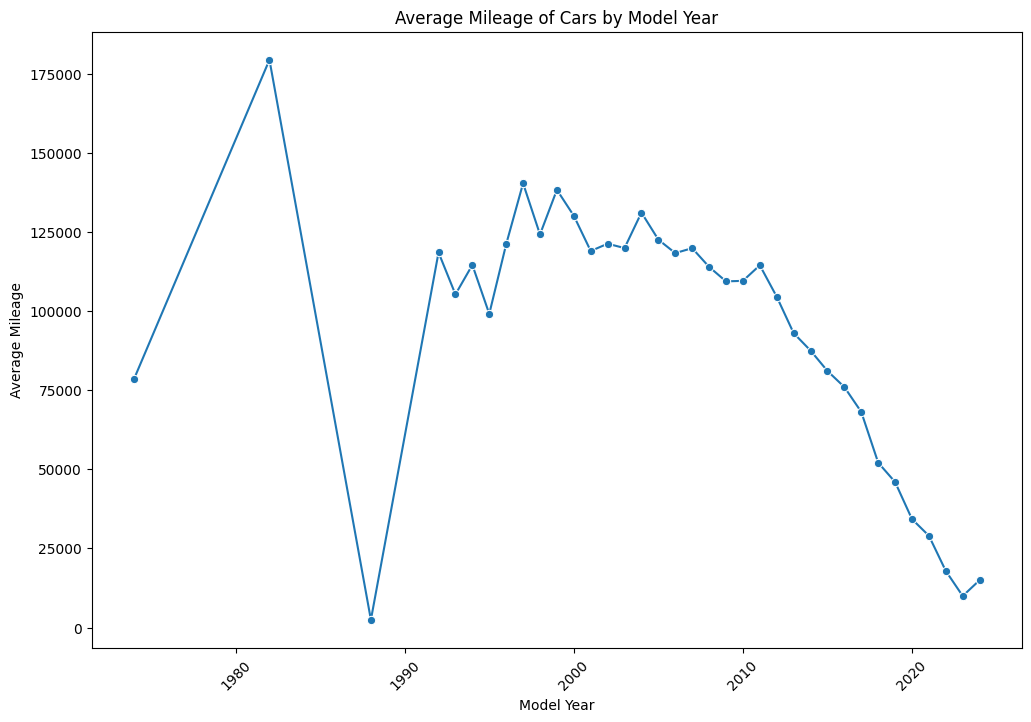

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

sns.lineplot(x='model_year', y='avg_milage', data=avg_mileage_by_year_pdf, marker='o')

plt.xlabel('Model Year')
plt.ylabel('Average Mileage')
plt.title('Average Mileage of Cars by Model Year')

plt.xticks(rotation=45)

plt.show()


In [20]:
numerical_data = sorted(numerical_columns)  

# Melting the df
f = df.selectExpr("stack({0}, {1}) as (variable, value)".format(
    len(numerical_data),
    ", ".join(f"'{col}', {col}" for col in numerical_data)
))

/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1500x1000 with 0 Axes>

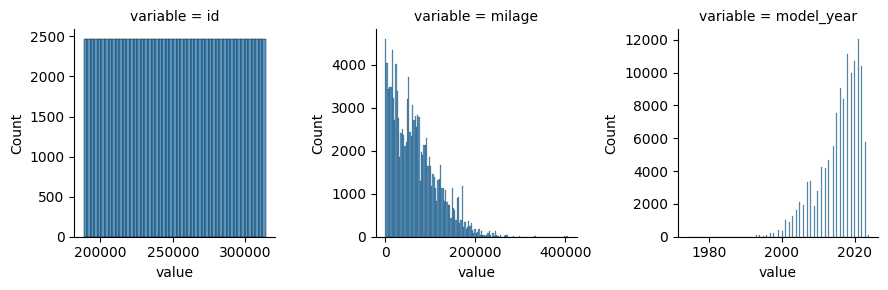

In [21]:
pandas_df = f.toPandas()
plt.figure(figsize=(15, 10))
g = sns.FacetGrid(pandas_df, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, 'value')
plt.show()


/home/lang_chain/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


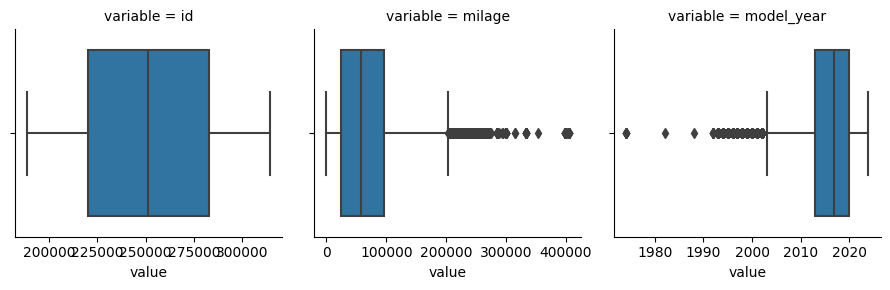

In [22]:
g_box = sns.FacetGrid(pandas_df, col='variable', col_wrap=4, sharex=False, sharey=False)
g_box.map(sns.boxplot, 'value')
plt.subplots_adjust(hspace=0.4)  

plt.show()

In [23]:
from pyspark.sql.functions import col, when, avg,median,count
for col_name in numerical_columns:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"Column '{col_name}' has {null_count} null values.")

In [24]:
for col_name in categorical_columns:
    null_count = df.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"Column '{col_name}' has {null_count} null values.")

Column 'fuel_type' has 3383 null values.
Column 'accident' has 1632 null values.
Column 'clean_title' has 14239 null values.


In [25]:
threshold = 2  

for feature in categorical_columns:
    feature_counts = df.groupBy(feature).agg(count('*').alias('count'))

    rare_features = feature_counts.filter(col('count') < threshold)

    rare_features_list = rare_features.collect()
    if rare_features_list:
        print(f"Rare features in '{feature}':")
        for row in rare_features_list:
            print(f"Value: {row[feature]}, Count: {row['count']}")
    else:
        print(f"No rare features found in '{feature}'.")

No rare features found in 'brand'.
Rare features in 'model':
Value: Evora 2+2, Count: 1
Value: Countryman Cooper S, Count: 1
Value: Silverado 3500 High Country, Count: 1
Value: Wagoneer Series II 4x4, Count: 1
Value: ForTwo Pure, Count: 1
Value: Z3 3.0i Roadster, Count: 1
Value: X6 sDrive35i, Count: 1
Value: X3 xDrive35i, Count: 1
Value: Model 3 Standard Range, Count: 1
Value: X5 sDrive35i, Count: 1
Value: IONIQ Plug-In Hybrid SEL, Count: 1
Value: IONIQ 5 SE, Count: 1
Value: X5 xDrive40e, Count: 1
Value: allroad 2.7T, Count: 1
Value: X5 3.0si, Count: 1
Value: Countryman Cooper, Count: 1
No rare features found in 'fuel_type'.
Rare features in 'engine':
Value: 208.0HP 3.3L V6 Cylinder Engine Gas/Electric Hybrid, Count: 1
Value: 266.0HP 2.5L 4 Cylinder Engine Plug-In Electric/Gas, Count: 1
Value: 111.2Ah / FR 70kW / RR 160kW (697V), Count: 1
Value: 275.0HP 3.5L V6 Cylinder Engine Flex Fuel Capability, Count: 1
Value: 3.2L V6 18V MPFI SOHC, Count: 1
Value: 78.0HP 1.2L 3 Cylinder Engine Gas

there are rare features in Model, engine

In [26]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="features")
vector_df = assembler.transform(df).select("features")
correlation_matrix = Correlation.corr(vector_df, "features").head()[0]
correlation_matrix_np = correlation_matrix.toArray()
correlation_df = pd.DataFrame(correlation_matrix_np, columns=numerical_columns, index=numerical_columns)
print(correlation_df)

                  id  model_year    milage
id          1.000000    0.001341 -0.002239
model_year  0.001341    1.000000 -0.675038
milage     -0.002239   -0.675038  1.000000


In [27]:
duplicates_df = (df
    .groupBy(df.columns)  
    .agg(F.count('*').alias('count'))
    .filter(F.col('count') > 1)
)
duplicates_df.show()

+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+
| id|brand|model|model_year|milage|fuel_type|engine|transmission|ext_col|int_col|accident|clean_title|count|
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+
+---+-----+-----+----------+------+---------+------+------------+-------+-------+--------+-----------+-----+



In [28]:
model_counts = df.groupBy('model').agg(count('model').alias('count')).orderBy('count')
model_counts.show(n=52)

+--------------------+-----+
|               model|count|
+--------------------+-----+
|Silverado 3500 Hi...|    1|
|           Evora 2+2|    1|
| Countryman Cooper S|    1|
|Wagoneer Series I...|    1|
|         ForTwo Pure|    1|
|    Z3 3.0i Roadster|    1|
|        X6 sDrive35i|    1|
|        X3 xDrive35i|    1|
|Model 3 Standard ...|    1|
|        X5 sDrive35i|    1|
|IONIQ Plug-In Hyb...|    1|
|          IONIQ 5 SE|    1|
|        X5 xDrive40e|    1|
|        allroad 2.7T|    1|
|            X5 3.0si|    1|
|   Countryman Cooper|    1|
|    2 Launch Edition|    2|
|GR Corolla Circui...|    2|
|        LYRIQ Luxury|    2|
|  500X Trekking Plus|    2|
|               XLR V|    2|
|Pacifica Hybrid T...|    2|
|        CT 200h Base|    2|
|           Mirage ES|    2|
|Sienna XSE 25th A...|    2|
|  Prius Plug-in Base|    2|
|        Model 3 Base|    2|
|     HS 250h Premium|    2|
|        X7 xDrive50i|    2|
|              STS V6|    2|
|            SX4 Base|    3|
|         Mave

In [29]:
engine_counts = df.groupBy('engine').agg(count('engine').alias('count')).orderBy('count') 
engine_counts.show(n=52)

+--------------------+-----+
|              engine|count|
+--------------------+-----+
|208.0HP 3.3L V6 C...|    1|
|266.0HP 2.5L 4 Cy...|    1|
|111.2Ah / FR 70kW...|    1|
|275.0HP 3.5L V6 C...|    1|
|3.2L V6 18V MPFI ...|    1|
|78.0HP 1.2L 3 Cyl...|    1|
|226.0HP 1.6L 4 Cy...|    1|
|111.0HP Electric ...|    2|
|240.0HP 2.5L 4 Cy...|    2|
|182.0HP 2.4L 4 Cy...|    2|
|369.0HP 3.0L Stra...|    2|
|444.0HP 4.7L 8 Cy...|    2|
|317.0HP 5.6L 8 Cy...|    2|
|1.6L I4 16V GDI DOHC|    2|
|141.0HP 2.0L 4 Cy...|    2|
|139.0HP 1.6L 4 Cy...|    2|
|134.0HP 1.8L 4 Cy...|    2|
|120.0HP 2.2L 4 Cy...|    2|
|164.0HP 1.4L 4 Cy...|    2|
|70.0HP 1.0L 3 Cyl...|    2|
|182.0HP Electric ...|    2|
|300.0HP 1.6L 3 Cy...|    3|
|197.0HP 1.6L 4 Cy...|    3|
|288.0HP 2.0L 4 Cy...|    3|
|280.0HP 2.8L V6 C...|    3|
|3.8L V6 12V MPFI OHV|    3|
|                2.5L|    3|
|184.0HP 2.4L 4 Cy...|    3|
|139.0HP 1.6L 4 Cy...|    3|
|180.0HP 6.5L 8 Cy...|    3|
|147.0HP Electric ...|    3|
|170.0HP 1.5L 